In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('house-prices-advanced-regression-techniques'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

house-prices-advanced-regression-techniques/test.csv
house-prices-advanced-regression-techniques/data_description.txt
house-prices-advanced-regression-techniques/train.csv
house-prices-advanced-regression-techniques/sample_submission.csv


In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [141]:
train_df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [142]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [143]:
train_df['SalePrice'].describe().round()

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

/var/folders/1k/z_z2n_6j3xxdhpz38rt_c5pw0000gn/T/ipykernel_22078/4271206055.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
/Users/imac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


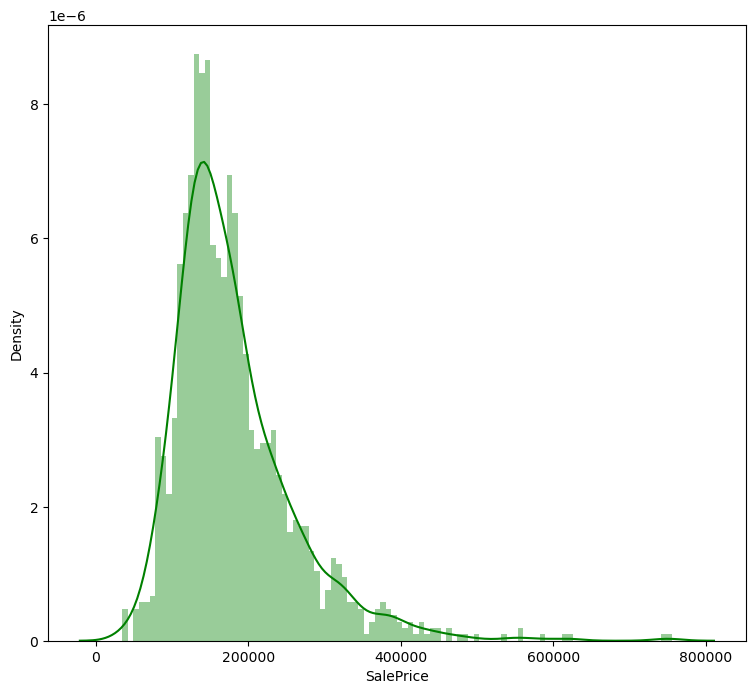

In [144]:
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
plt.savefig('price_dist.png')

In [145]:
train_df.dtypes[train_df.dtypes!='object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [146]:
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

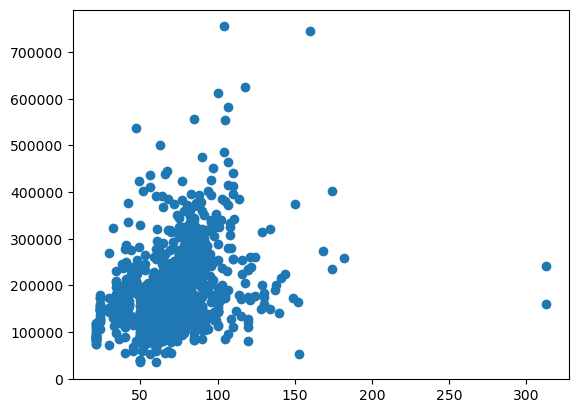

In [21]:
plt.scatter(x='LotFrontage',y='SalePrice', data=train_df)

In [22]:
train_df.query('LotFrontage>300')
#Drop 935, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


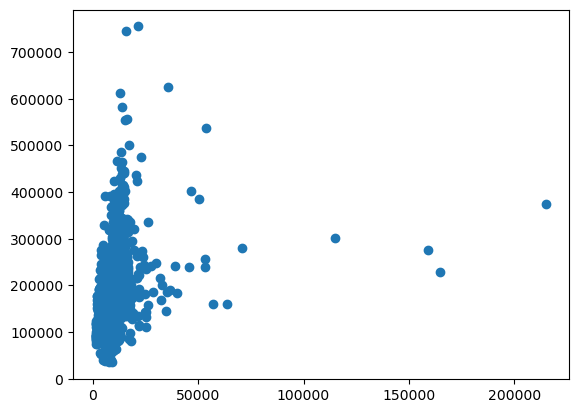

In [23]:
plt.scatter(x='LotArea',y='SalePrice', data=train_df)

In [24]:
train_df.query('LotArea>55000')
#Drop 250, 314, 336, 707

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [26]:
stats.zscore(train_df['LotArea']).sort_values().tail(10)
# delete 313, 335, 706, 249

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

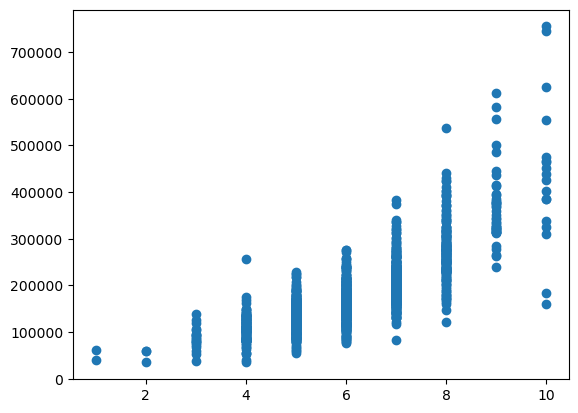

In [27]:
plt.scatter(x='OverallQual',y='SalePrice', data=train_df)

In [28]:
train_df.query('OverallQual==10 & (SalePrice<200000 or SalePrice>700000)')
#Drop 524, 692, 1183, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


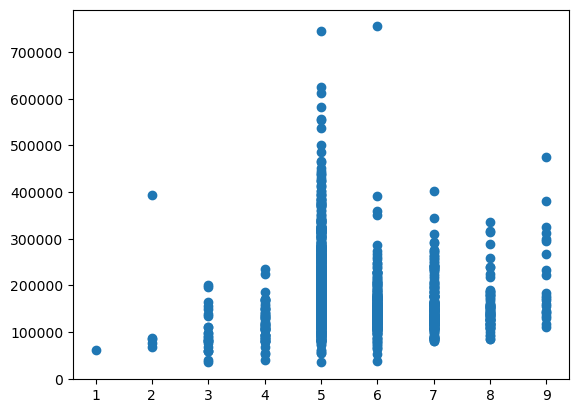

In [29]:
plt.scatter(x='OverallCond',y='SalePrice',data=train_df)

In [30]:
train_df.query('OverallCond==2  & SalePrice>300000')
#Drop 692, 1183, 379

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
378,379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


In [31]:
stats.zscore(train_df['OverallCond']).sort_values().head(10)

375    -4.112970
378    -3.214027
88     -3.214027
398    -3.214027
676    -3.214027
250    -3.214027
1035   -2.315085
942    -2.315085
1223   -2.315085
344    -2.315085
Name: OverallCond, dtype: float64

In [32]:
train_df[train_df['OverallCond']==6][train_df['SalePrice']>700000]
#delete 379, 692

/var/folders/1k/z_z2n_6j3xxdhpz38rt_c5pw0000gn/T/ipykernel_22078/2392874537.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[train_df['OverallCond']==6][train_df['SalePrice']>700000]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


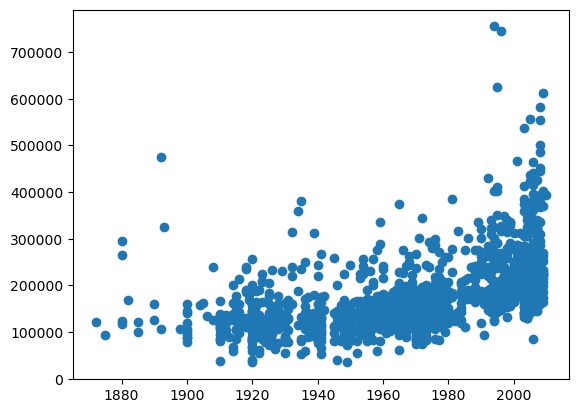

In [33]:
plt.scatter(x='YearBuilt',y='SalePrice',data=train_df)

In [34]:
train_df.query('YearBuilt<1900 & SalePrice>400000')
#Drop 692, 1183, 186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


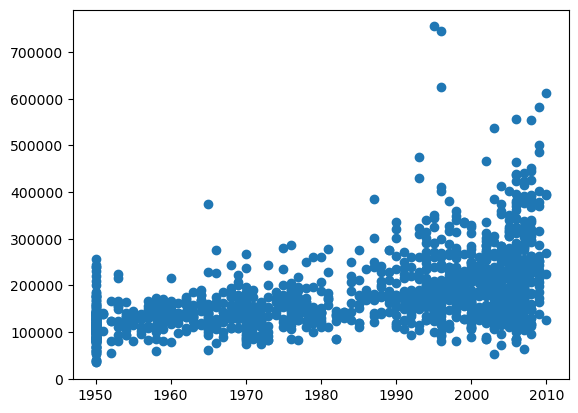

In [35]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train_df)

In [36]:
#in the same way look for all other outliers and construct a values vector
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [37]:
#delete outlier instances
train_df = train_df[train_df.Id.isin(values) == False]

In [38]:
#create a dataframe of null values (that are present in the train_df)
train_df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1435
MiscFeature     1388
Alley           1350
Fence           1162
MasVnrType       861
FireplaceQu      684
LotFrontage      255
GarageYrBlt       76
GarageCond        76
GarageType        76
GarageFinish      76
GarageQual        76
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

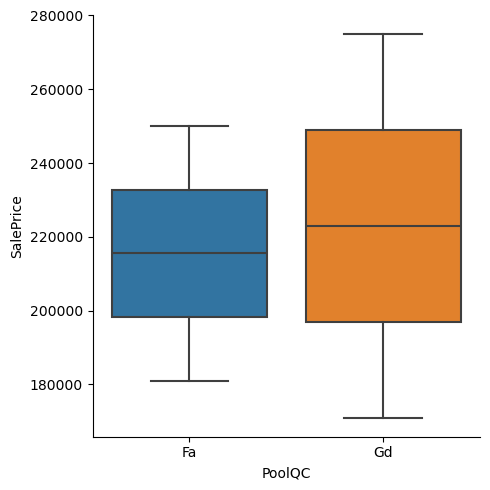

In [39]:
sns.catplot(data=train_df, x="PoolQC", y="SalePrice", kind="box")

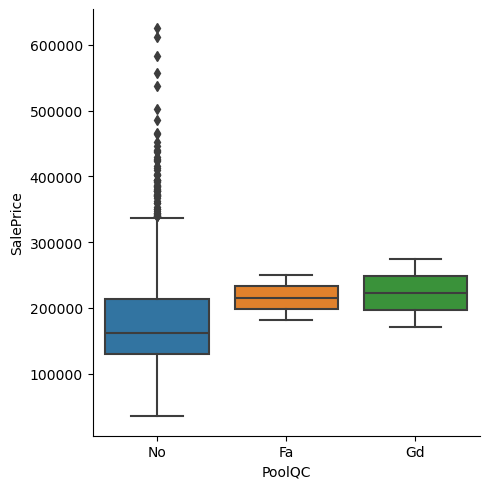

In [40]:
train_df['PoolQC'].fillna('No', inplace=True)
test_df['PoolQC'].fillna('No', inplace=True)
sns.catplot(data=train_df, x="PoolQC", y="SalePrice", kind="box")

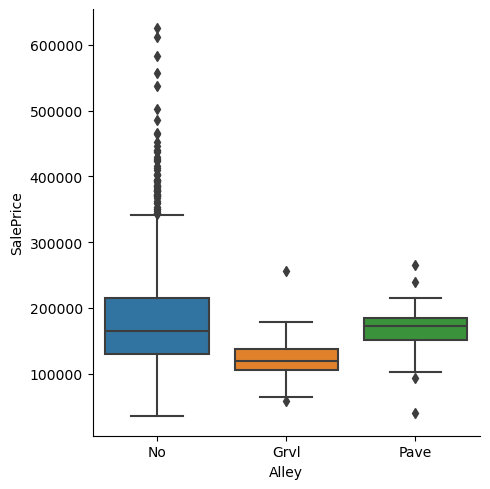

In [41]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="Alley", y="SalePrice", kind="box")

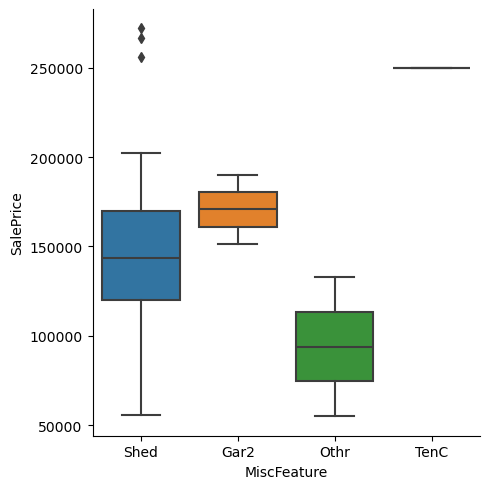

In [42]:
sns.catplot(data=train_df, x="MiscFeature", y="SalePrice", kind="box")

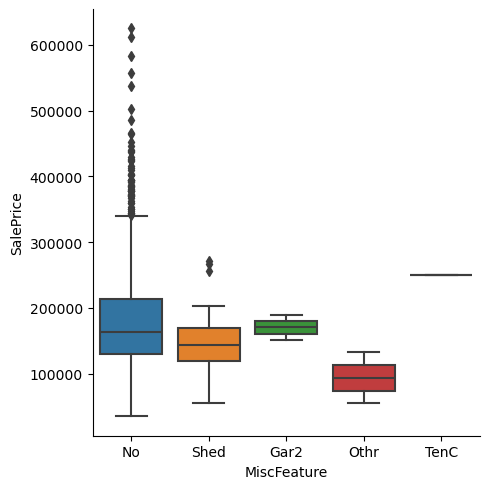

In [43]:
train_df['MiscFeature'].fillna('No', inplace=True)
test_df['MiscFeature'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="MiscFeature", y="SalePrice", kind="box")

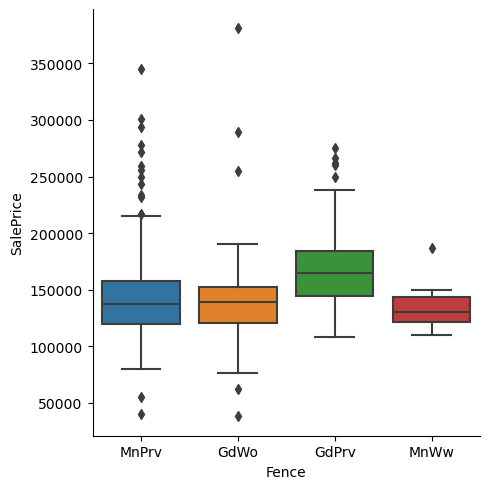

In [44]:
sns.catplot(data=train_df, x="Fence", y="SalePrice", kind="box")

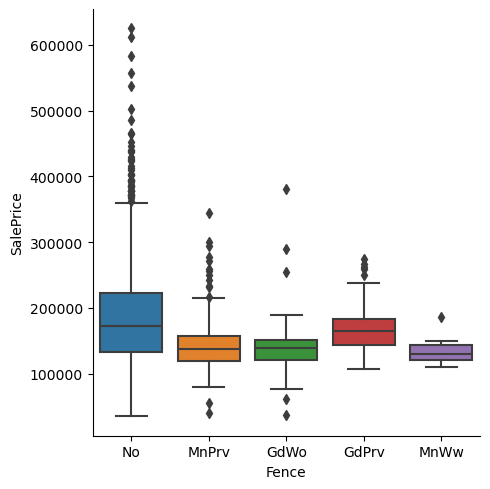

In [45]:
train_df['Fence'].fillna('No', inplace=True)
test_df['Fence'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="Fence", y="SalePrice", kind="box")

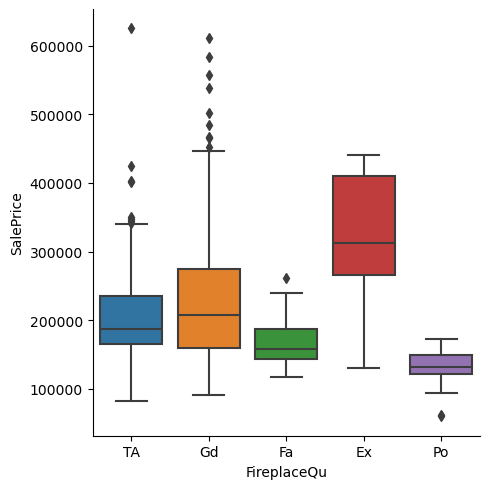

In [46]:


sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

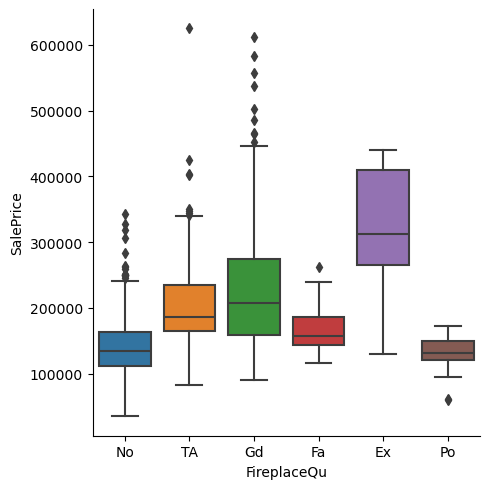

In [47]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

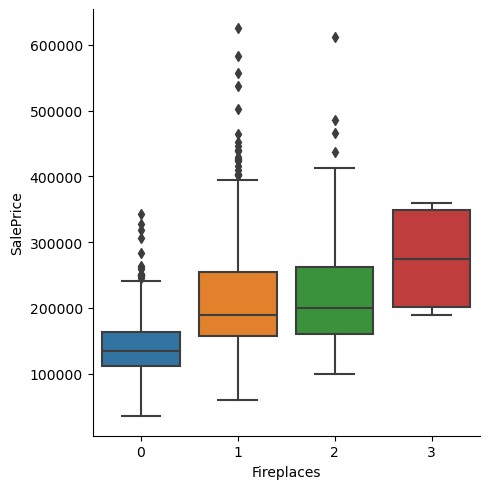

In [48]:

sns.catplot(data=train_df, x="Fireplaces", y="SalePrice", kind="box")

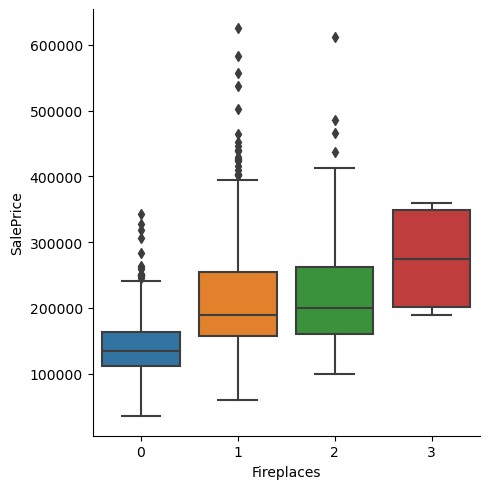

In [49]:
train_df['Fireplaces'].fillna('No', inplace=True)
test_df['Fireplaces'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="Fireplaces", y="SalePrice", kind="box")

In [50]:
train_df['Fireplaces'].isnull().sum()

0

In [51]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [52]:
"""
in the same way drop these too bc they have too many null/na values

MasVnrType       861
FireplaceQu      684
LotFrontage      255
"""

'\nin the same way drop these too bc they have too many null/na values\n\nMasVnrType       861\nFireplaceQu      684\nLotFrontage      255\n'

In [53]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

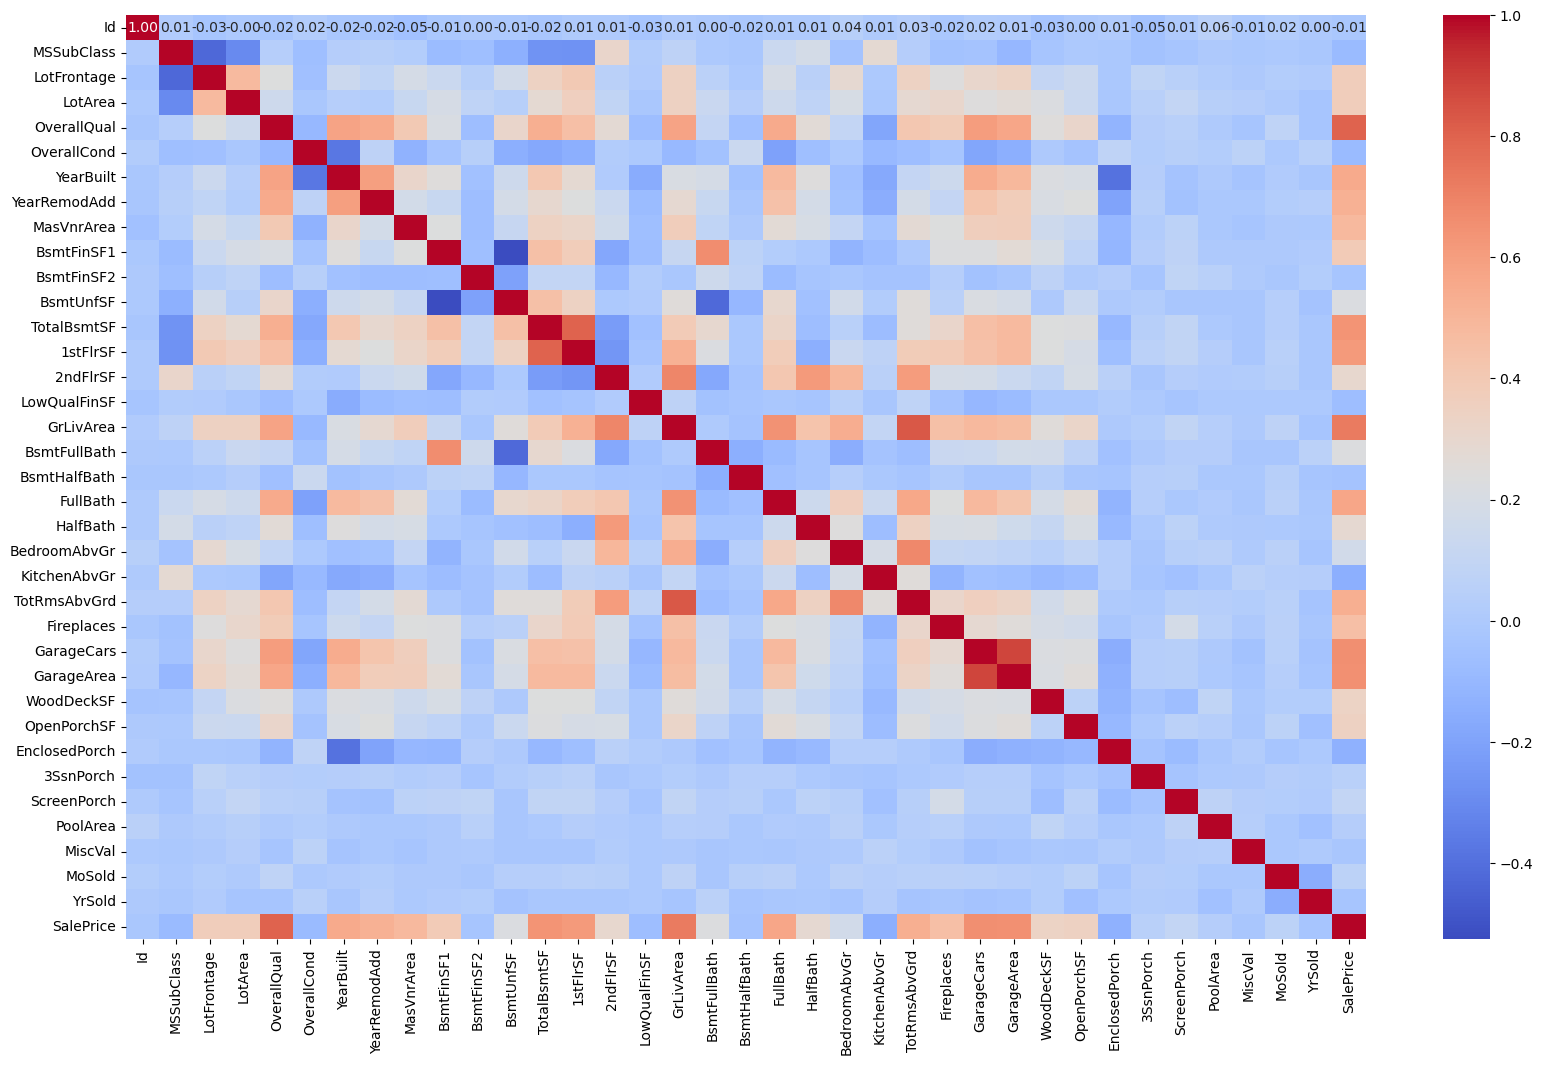

In [54]:
#let's drop some highly correlated features here (we will drop more of those too along the way)
matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.savefig('seaborn_plot.png')

In [55]:
#GarageArea and GarageCars are highly correlated with value over 0.89.
#so consider doropping one of them. both parameters together between them double their effect
#on the model

#another pair is YearBuilt and GarageYearBuilt
#TotRmsAbGrd and GrLivArea
#for that matter here are all highly correlated features:

corr_df=train_df.select_dtypes(include=np.number)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, n):
    corr = df.corr()
    au_corr = corr.unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(key=lambda x: x.abs(), ascending=False)
    return au_corr[0:n]

print("Top Correlations (Positive and Negative)")
print(get_top_correlations(corr_df, 4))


Top Correlations (Positive and Negative)
GarageCars   GarageArea      0.885534
GrLivArea    TotRmsAbvGrd    0.831634
TotalBsmtSF  1stFlrSF        0.801055
OverallQual  SalePrice       0.800050
dtype: float64


In [56]:
'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'

('PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'GarageYrBlt',
 'GarageCond',
 'BsmtFinType2')

In [57]:
train_df = train_df.drop(columns=['GarageCars', 'TotRmsAbvGrd'])
test_df = test_df.drop(columns=['GarageCars', 'TotRmsAbvGrd'])

In [203]:
#if error above, it's bc the cell was run twice. no worries

/Users/imac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

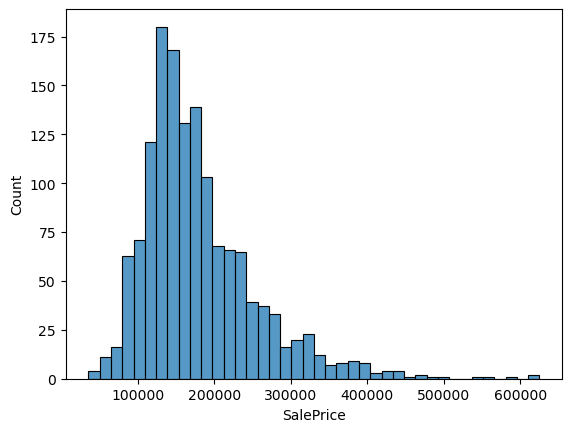

In [58]:
#take a look at price distribution
sns.histplot(train_df, x=train_df['SalePrice'])

/Users/imac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

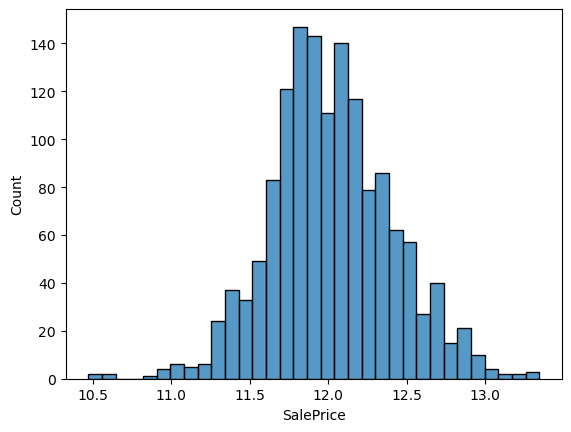

In [59]:
#apply log to sales price to normalize it
train_df['SalePrice']=np.log1p(train_df['SalePrice'])
sns.histplot(train_df, x=train_df['SalePrice'])

### turning qualititative columns into quantititative ones using ordinal and one hot encoding

In [60]:
#numerical data
train_df.dtypes[train_df.dtypes!='object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
Fireplaces         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
dtype: object

In [61]:
#categorical data
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

### get categorical colums and sort by encoding columns
- ordinal encoding for ordinal categorical data like slope(mod, steep, severe)
- one hot encoding for non-ordinal cat data like hair color (red, pink, green)

In [62]:
obj_cols = train_df.select_dtypes(include=['object']).columns
obj_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [63]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [64]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [65]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [66]:
num_cols=num_cols.drop('SalePrice')

### pipelines

In [67]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [68]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [69]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### column transformer

In [70]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [71]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [72]:
train_df['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1439, dtype: float64

In [73]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [74]:
X_preprocessed = pipeline.fit_transform(X)

In [75]:
X_preprocessed.shape

(1439, 204)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

## models

In [77]:
lr = LinearRegression()

In [78]:
lr.fit(X_train, y_train)

LinearRegression()

In [79]:
y_pred_lr = lr.predict(X_test)

In [80]:
mean_squared_error(y_test, y_pred_lr)

4.1213412613987526e+20

In [81]:
RFR = RandomForestRegressor(random_state=13)

In [82]:
param_grid_RFR = {
    'max_depth': [5,10,15],
    'n_estimators': [100,250,500],
    'min_samples_split': [3,5,10]
}

In [83]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=1)

In [84]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [85]:
np.sqrt(-1*rfr_cv.best_score_)

0.14075756334817166

In [86]:
XGB = XGBRegressor(random_state=13)

In [87]:
param_grid_XGB= {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [88]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [89]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [91]:
np.sqrt(-1*xgb_cv.best_score_)

0.12237745734370123

In [110]:
ridge= Ridge()

In [111]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [112]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [113]:
ridge_cv.fit(X_train, y_train)

/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [114]:
np.sqrt(-1 * ridge_cv.best_score_)

0.10864111239551476

In [92]:
GBR = GradientBoostingRegressor()

In [93]:
param_grid_GBR = {
    'max_depth': [12,15,20],
    'n_estimators': [200,300,1000],
    'min_samples_leaf': [10.25,50],
    'learning_rate': [0.001,0.01,0.1],
    'max_features':[0.01,0.01,0.1]
}

In [105]:
GBR_cv=GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [106]:
GBR_cv.fit(X_train,y_train)

/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/Users/imac/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/Users/ima

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.01, 0.1],
                         'min_samples_leaf': [10.25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [108]:
np.sqrt(-1*GBR_cv.best_score_)

0.12142830262149948

In [98]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [99]:
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [100]:
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [101]:
cat_cv.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x13e855e10>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [109]:
np.sqrt(-1*cat_cv.best_score_)

0.11590779034860674

In [115]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

In [116]:
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=20,
                                                       max_features=0.1,
                                                       min_samples_leaf=50,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_m...
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=2,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=5, solver='lsqr'))],
                weights=[2, 3, 1])

In [117]:
y_pred_vr = vr.predict(X_test)

In [118]:
mean_squared_error(y_test, y_pred_vr, squared=False)

0.11862220767741186

In [120]:
lgbm_regressor = lgb.LGBMRegressor()

In [121]:
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [122]:
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [123]:
lgbm_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 111
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 112
[LightGBM] [Info] Number of data poi

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_mean_squared_error')

In [124]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.1283028005886862

In [125]:
estimators = [
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [126]:
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

In [127]:
stackreg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 121
[LightGBM] [Info] Start training from score 12.023259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3099
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 115
[LightGBM] [Info] Start training from score 12.032469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=20,
                                                         max_features=0.1,
                                                         min_samples_leaf=50,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.1,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=2,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=5,
                                                                     solver='lsqr'))],
                                                  weights=[2, 3, 1]))

In [128]:
y_pred_stack = stackreg.predict(X_test)

In [129]:
mean_squared_error(y_test, y_pred_stack, squared=False)

0.11959065510904583

In [130]:
df_test_preprocess = pipeline.transform(test_df)

In [131]:
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

/var/folders/1k/z_z2n_6j3xxdhpz38rt_c5pw0000gn/T/ipykernel_22078/176896153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
